# Parameter space figure

In [4]:
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")
from brian2 import *
from collections import OrderedDict
from scipy.interpolate import interp1d
from matplotlib import cm
from matplotlib.gridspec import GridSpecFromSubplotSpec
import joblib
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.filters import gaussian_filter, median_filter, minimum_filter
from simple_model import *
from simple_model import mem
from model_explorer_jupyter import meshed_arguments
import itertools
import numba

def normed(X, *args):
    m = max(amax(abs(Y)) for Y in (X,)+args)
    return X/m

Error functions

In [5]:
def rmse(x, y, axis=1):
    return sqrt(mean((x-y)**2, axis=axis))

def maxnorm(x, y, axis=1):
    return amax(abs(x-y), axis=axis)

error_functions = {
    'RMS error': rmse,
    'Max error': maxnorm,
    }

Parameter names

In [6]:
latex_parameter_names = dict(
    taue_ms=r"$\tau_e$ (ms)",
    taui_ms=r"$\tau_i$ (ms)",
    taua_ms=r"$\tau_a$ (ms)",
    alpha=r"$\alpha$",
    beta=r"$\beta$",
    gamma=r"$\gamma$",
    level=r"$L$ (dB)",
    )

Run analysis and plot figure

Image dimension 22x22, approximately 103 samples per pixel


<IPython.core.display.Javascript object>


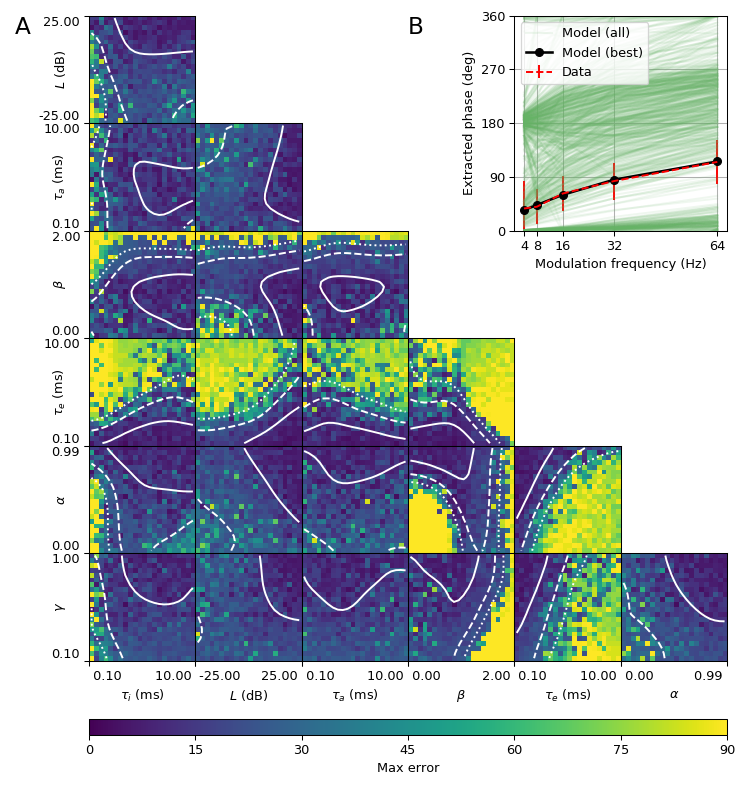

Best: 2.9 +/- 0.9 deg at taui_ms=3.63, level=16.07, taua_ms=9.05, beta=0.84, taue_ms=0.12, alpha=0.52, gamma=0.57
Fraction of curves nonzero 63.4%
Fraction monotonically increasing 70.6%


In [7]:
from scipy import stats

# # Take a series of x, y points and plot a density map using kernel density estimation
# # N is the grid size for the density image

def density_map(x, y, N, xmin=None, xmax=None, ymin=None, ymax=None):
    # Peform the kernel density estimate
    if xmin is None:
        xmin = amin(x)
    if xmax is None:
        xmax = amax(x)
    if ymin is None:
        ymin = amin(y)
    if ymax is None:
        ymax = amax(y)
    xx, yy = mgrid[xmin:xmax:N*1j, ymin:ymax:N*1j]
    positions = vstack([xx.ravel(), yy.ravel()])
    values = vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    extent = (xmin, xmax, ymin, ymax)
    return f.T, extent

def plot_density_map(x, y, N, xmin=None, xmax=None, ymin=None, ymax=None, **args):
    img, extent = density_map(x, y, N, xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax)
    imshow(img, origin='lower left', aspect='auto', interpolation='nearest',
           extent=extent,
           vmin=0, vmax=amax(img),#/0.7,
           **args
           )

# Take a series of x, y points and plot a density map using kernel density estimation
# N is the grid size for the density image. For the independent density map it shows
# the ratio of the density of the joint density to what you'd expect if the variables
# were independent

def independent_density_map(x, y, N, xmin=None, xmax=None, ymin=None, ymax=None):
    # Peform the kernel density estimate
    if xmin is None:
        xmin = amin(x)
    if xmax is None:
        xmax = amax(x)
    if ymin is None:
        ymin = amin(y)
    if ymax is None:
        ymax = amax(y)
    xx, yy = mgrid[xmin:xmax:N*1j, ymin:ymax:N*1j]
    xxx = linspace(xmin, xmax, N)
    yyy = linspace(ymin, ymax, N)
    positions = vstack([xx.ravel(), yy.ravel()])
    values = vstack([x, y])
    kernel = stats.gaussian_kde(values)
    kernelx = stats.gaussian_kde(x)
    kernely = stats.gaussian_kde(y)
    f = log(np.reshape(kernel(positions).T, xx.shape)/(kernelx(xxx)[newaxis, :]*kernely(yyy)[:, newaxis]))
    extent = (xmin, xmax, ymin, ymax)
    return f.T, extent

def plot_independent_density_map(x, y, N, xmin=None, xmax=None, ymin=None, ymax=None, **args):
    img, extent = independent_density_map(x, y, N, xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax)
    imshow(img, origin='lower left', aspect='auto', interpolation='nearest',
           extent=extent, cmap=cm.coolwarm,
           vmin=-2, vmax=2,
           **args
           )
    
def parameter_space(N, search_params, N_show=1000, transp=0.1,
                    weighted=False, error_func_name="Max error",
                    max_error=30, plotmode='scatter',
                    error_upper_cutoff=90,
                    show_samples=True,
                    subdivide_for_std_calc=10,
                    ):
    search_params_all = search_params
    search_params = dict((k, v) for k, v in search_params.items() if isinstance(v, tuple))
    figtitle = plotmode
    if plotmode=='density':
        density_plotter = plot_density_map
    elif plotmode=='independent_density':
        plotmode = 'density'
        density_plotter = plot_independent_density_map
    elif plotmode=='error':
        # aim for at least 100 params per pixel, but only need 40x40 max pixels
        N_img = min(int(sqrt(N/100.)), 40)
        print 'Image dimension {N_img}x{N_img}, approximately {samp} samples per pixel'.format(
                    N_img=N_img, samp=int(N/N_img**2))
    # always use the same random seed for cacheing
    seed(34032483)
    # Get simple parameters
    error_func = error_functions[error_func_name]
    # Run the model
    res = simple_model(N, search_params_all, use_standalone_openmp=True, update_progress='text')
    res = simple_model_results(N, res, error_func, weighted=weighted, interpolate_bmf=False)
    mse = res.mse
    meanvs = mean(res.raw_measures['vs'], axis=1)
    good_indices = mse<max_error*pi/180
    regions = [('All', good_indices, 'blue')]
    # Plot parameter pairs
    mainfig = figure(figsize=(8, 8.5), dpi=85)
    #suptitle(figtitle)
    nparam = len(search_params)
    gs = GridSpec(nparam-1, nparam-1, wspace=0, hspace=0)
    image_axes = []
    for i in xrange(nparam):
        for j in xrange(i+1, nparam):
            px = search_params.keys()[i]
            py = search_params.keys()[j]
            vx = res.raw.params[px]
            vy = res.raw.params[py]
            xmin, xmax = search_params[px]
            ymin, ymax = search_params[py]
            image_axes.append(subplot(gs[j-1, i]))
            if plotmode=='error':
                error = 2*pi*ones((N_img, N_img))
                @numba.jit(nopython=True)
                def find_best_error(error, vx, vy, mse, xmin, xmax, ymin, ymax):
                    N = error.shape[0]
                    wx = float(xmax-xmin)/N
                    wy = float(ymax-ymin)/N
                    for k in range(mse.shape[0]):
                        x = vx[k]
                        y = vy[k]
                        i = int((x-xmin)/wx)
                        j = int((y-ymin)/wy)
                        if mse[k]<error[i, j]:
                            error[i, j] = mse[k]
                find_best_error(error, vx, vy, mse, xmin, xmax, ymin, ymax)
                error = error.T*180/pi
                #error = median_filter(error, size=5, mode='nearest')
                #error = minimum_filter(error, size=3, mode='nearest')
                error_blur = gaussian_filter(error, 3, mode='nearest')
                img_obj = imshow(error, extent=(xmin, xmax, ymin, ymax),
                       origin='lower left', aspect='auto', interpolation='nearest',
                       vmin=0, vmax=error_upper_cutoff, cmap=cm.viridis)
                cs = contour(error_blur, origin='lower',
                             levels=[15, 30, 45], colors='w',
                             extent=(xmin, xmax, ymin, ymax))
                # this weird hack works around a bug in contour
                for level, linecol in zip(cs.levels, cs.collections):
                    if level==15:
                        linecol.set_linestyle('solid')
                    if level==30:
                        linecol.set_linestyle('dashed')
                    if level==45:
                        linecol.set_linestyle('dotted')
            else:
                for condname, cond, condcol in regions:
                    rvx = vx[cond]
                    rvy = vy[cond]
                    if plotmode=='scatter':
                        plot(rvx, rvy, ',', c=condcol)
                    elif plotmode=='density':
                        density_plotter(rvx, rvy, 40,
                                        xmin=xmin, ymin=ymin,
                                        xmax=xmax, ymax=ymax,
                                        )
            xlim(*search_params[px])
            ylim(*search_params[py])
            if j==nparam-1:
                xlabel(latex_parameter_names[px])
                xticks(search_params[px], ['%.2f' % paramval for paramval in search_params[px]])
                ticklabels = gca().get_xticklabels()
                ticklabels[0].set_ha('left')
                ticklabels[0].set_text(' '+ticklabels[0].get_text())
                ticklabels[-1].set_ha('right')
                ticklabels[-1].set_text(ticklabels[-1].get_text()+' ')
                #print ticklabels[0]
                #print ticklabels
                gca().set_xticklabels(ticklabels)
            else:
                xticks([])
            if i==0:
                yticks(search_params[py], ['%.2f' % paramval for paramval in search_params[py]])
                ticklabels = gca().get_yticklabels()
                ticklabels[0].set_va('bottom')
                ticklabels[-1].set_va('top')
                ylabel(latex_parameter_names[py])
                gca().get_yaxis().set_label_coords(-0.2,0.5)
            else:
                yticks([])
    
    # Plot some sample extracted phase curves
    peak_phase = res.peak_phase
    # Properties of lowest MSE value
    # std of best mse by subdividing data
    bests = []
    for i in range(subdivide_for_std_calc):
        bests.append(amin(mse[N/subdivide_for_std_calc*i:N/subdivide_for_std_calc*(i+1)]))
    mse_best_std = std(bests)*180/pi
    idx_best = argmin(mse)
    best_peak_phase = peak_phase[idx_best, :]
    bestvals = []
    for k in search_params.keys():
        v = res.raw.params[k][idx_best]
        bestvals.append('%s=%.2f' % (k, v))
    print ('Best: %.1f +/- %.1f deg at '%(mse[idx_best]*180/pi, mse_best_std)) + ', '.join(bestvals)
    
    if show_samples:
        subplot(gs[0:2, nparam-3:nparam-1])
    else:
        figure(figsize=(5, 5))

    # We only want to show N_show good peak phase curves, so we apply some criteria
    #idx_keep = amax(peak_phase, axis=1)>1*pi/180
    #idx_keep = idx_keep & (amin(peak_phase, axis=1)>0)
    #idx_keep = idx_keep & (amin(peak_phase, axis=1)<=pi)
    #idx_keep = idx_keep & (amax(abs(diff(peak_phase, axis=1)), axis=1)<pi/2)
    idx_keep = amin(peak_phase, axis=1)>0
    print "Fraction of curves nonzero %.1f%%" % (100.0*sum(idx_keep)/N)
    idx_keep = idx_keep[:N_show]
    idx_keep, = idx_keep.nonzero()
    # Plot the extracted phase curves
    unrolled = peak_phase[idx_keep, 0][:, newaxis]+cumsum(hstack((zeros((len(idx_keep), 1)), log(exp(1j*diff(peak_phase[idx_keep, :], axis=1))).imag)), axis=1)
    print "Fraction monotonically increasing %.1f%%" % (sum((diff(unrolled, axis=1)>0).all(axis=1))*100.0/len(idx_keep))
    #plot(dietz_fm/Hz, peak_phase[idx_keep, :].T*180/pi, '-', color=(0.4, 0.7, 0.4, transp), label='Model (all)')
    plot(dietz_fm/Hz, unrolled.T*180/pi, '-', color=(0.4, 0.7, 0.4, transp), label='Model (all)')
    plot(dietz_fm/Hz, unrolled.T*180/pi+360, '-', color=(0.4, 0.7, 0.4, transp))
    plot(dietz_fm/Hz, unrolled.T*180/pi-360, '-', color=(0.4, 0.7, 0.4, transp))
    plot(dietz_fm/Hz, best_peak_phase*180/pi, '-ko', lw=2, label='Model (best)')
    errorbar(dietz_fm/Hz, dietz_phase*180/pi, yerr=dietz_phase_std*180/pi, fmt='--r', label='Data')
    handles, labels = gca().get_legend_handles_labels()
    lab2hand = OrderedDict()
    for h, l in zip(handles, labels):
        lab2hand[l] = h
    legend(lab2hand.values(), lab2hand.keys(), loc='upper left')
    grid()
    ylim(0, 360)
    yticks([0, 90, 180, 270, 360])
    xticks(dietz_fm/Hz)
    xlabel('Modulation frequency (Hz)')
    ylabel('Extracted phase (deg)')
        
    mainfig.subplots_adjust(left=0.12, right=0.98, bottom=0.05, top=0.98)
    
    cb = mainfig.colorbar(img_obj, ax=mainfig.axes, use_gridspec=True,
             ticks=range(0, 121, 15),
             orientation='horizontal',
             fraction=0.04, pad=0.08, aspect=40,
            )
    cb.set_label(error_func_name)#, rotation=270, labelpad=20)
    
    if show_samples:
        for c, xpos in [('A', 0.02), ('B', 0.55)]:
            text(xpos, 0.98, c, fontsize=18, transform=gcf().transFigure,
                 horizontalalignment='left', verticalalignment='top')

        
search_params = dict(
    taui_ms=(0.1, 10), taue_ms=(0.1, 10), taua_ms=(0.1, 10),
    level=(-25, 25), alpha=(0, 0.99), beta=(0, 2),
    gamma=(0.1, 1))

#for plotmode in ['error', 'scatter', 'density', 'independent_density']:
parameter_space(N=50000, search_params=search_params, plotmode='error')
#parameter_space(N=800000, search_params=search_params, plotmode='error')
#parameter_space(N=4000000, search_params=search_params, plotmode='error')

savefig('figure_parameter_space.pdf')

<IPython.core.display.Javascript object>


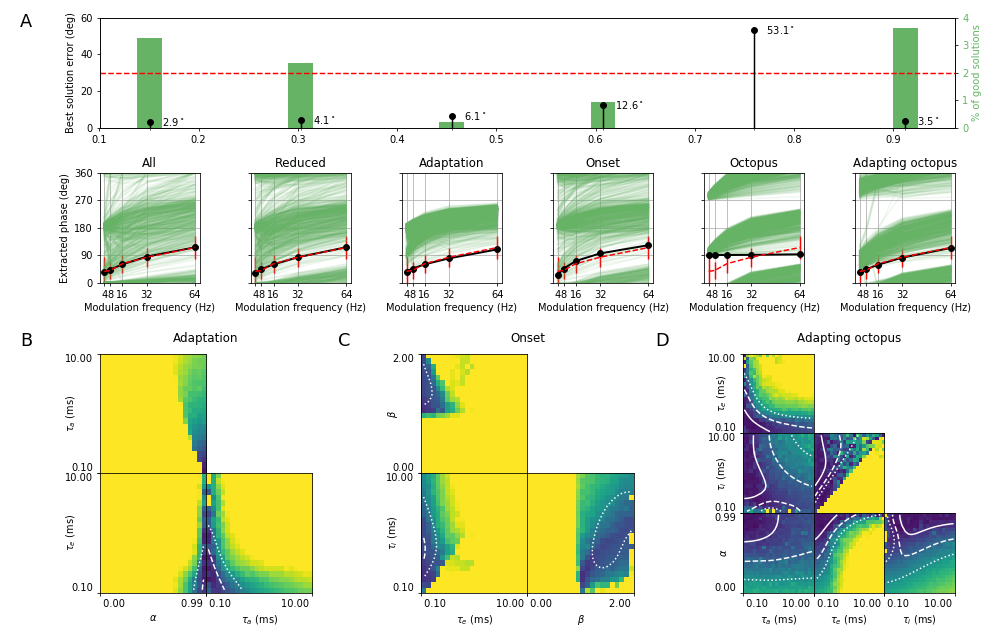

Best: 2.9 at taui_ms=3.63, level=16.07, taua_ms=9.05, beta=0.84, alpha=0.52, taue_ms=0.12, gamma=0.57
Fraction of curves nonzero 63.4%
Fraction monotonically increasing 70.6%
Best: 4.1 at taua_ms=0.79, taue_ms=1.43, beta=0.84, taui_ms=6.75, alpha=0.97
Fraction of curves nonzero 71.7%
Fraction monotonically increasing 64.8%
Best: 6.1 at alpha=0.98, taua_ms=0.52, taue_ms=1.42
Fraction of curves nonzero 100.0%
Fraction monotonically increasing 69.6%
Best: 12.6 at taue_ms=0.36, beta=1.08, taui_ms=1.77
Fraction of curves nonzero 72.3%
Fraction monotonically increasing 69.5%
Best: 53.1 at taue_ms=0.10, taui_ms=0.17
Fraction of curves nonzero 99.5%
Fraction monotonically increasing 100.0%
Best: 3.5 at taua_ms=1.68, taue_ms=1.01, taui_ms=2.16, alpha=0.84
Fraction of curves nonzero 98.3%
Fraction monotonically increasing 94.3%
Image dimension 22x22, approximately 103 samples per pixel
Image dimension 22x22, approximately 103 samples per pixel
Image dimension 22x22, approximately 103 samples per

In [8]:
def sample_curves(N, search_params,
                  N_show=1000, transp=0.1, show_legend=False,
                  weighted=False, error_func_name="Max error",
                  max_error=30,
                  ):
    search_params_all = search_params
    search_params = dict((k, v) for k, v in search_params.items() if isinstance(v, tuple))
    # always use the same random seed for cacheing
    seed(34032483)
    # Get simple parameters
    error_func = error_functions[error_func_name]
    # Run the model
    res = simple_model(N, search_params_all, use_standalone_openmp=True, update_progress='text')
    res = simple_model_results(N, res, error_func, weighted=weighted, interpolate_bmf=False)
    mse = res.mse
    meanvs = mean(res.raw_measures['vs'], axis=1)
    good_indices = mse<max_error*pi/180
    fraction_good = sum(good_indices)*1.0/len(good_indices)
    # Plot some sample extracted phase curves
    peak_phase = res.peak_phase
    # Properties of lowest MSE value
    idx_best = argmin(mse)
    best_peak_phase = peak_phase[idx_best, :]
    bestvals = []
    for k in search_params.keys():
        v = res.raw.params[k][idx_best]
        bestvals.append('%s=%.2f' % (k, v))
    best_deg = mse[idx_best]*180/pi
    print ('Best: %.1f at ' % best_deg) + ', '.join(bestvals)
    
    # We only want to show N_show good peak phase curves, so we apply some criteria
    idx_keep = amin(peak_phase, axis=1)>0
    print "Fraction of curves nonzero %.1f%%" % (100.0*sum(idx_keep)/N)
    idx_keep = idx_keep[:N_show]
    idx_keep, = idx_keep.nonzero()
    # Plot the extracted phase curves
    unrolled = peak_phase[idx_keep, 0][:, newaxis]+cumsum(hstack((zeros((len(idx_keep), 1)), log(exp(1j*diff(peak_phase[idx_keep, :], axis=1))).imag)), axis=1)
    print "Fraction monotonically increasing %.1f%%" % (sum((diff(unrolled, axis=1)>0).all(axis=1))*100.0/len(idx_keep))
    plot(dietz_fm/Hz, unrolled.T*180/pi, '-', color=(0.4, 0.7, 0.4, transp), label='Model (all)')
    plot(dietz_fm/Hz, unrolled.T*180/pi+360, '-', color=(0.4, 0.7, 0.4, transp))
    plot(dietz_fm/Hz, unrolled.T*180/pi-360, '-', color=(0.4, 0.7, 0.4, transp))
    plot(dietz_fm/Hz, best_peak_phase*180/pi, '-ko', lw=2, label='Model (best)')
    errorbar(dietz_fm/Hz, dietz_phase*180/pi, yerr=dietz_phase_std*180/pi, fmt='--r', label='Data')
    if show_legend:
        handles, labels = gca().get_legend_handles_labels()
        lab2hand = OrderedDict()
        for h, l in zip(handles, labels):
            lab2hand[l] = h
        legend(lab2hand.values(), lab2hand.keys(), loc='upper left')
    grid()
    ylim(0, 360)
    yticks([0, 90, 180, 270, 360])
    xticks(dietz_fm/Hz)
    xlabel('Modulation frequency (Hz)')
    ylabel('Extracted phase (deg)')
    
    return best_deg, fraction_good

def parameter_maps(N, search_params, subplot_spec,
                   weighted=False, error_func_name="Max error",
                   max_error=30, error_upper_cutoff=90,
                   ):
    search_params_all = search_params
    search_params = dict((k, v) for k, v in search_params.items() if isinstance(v, tuple))
    # aim for at least 100 params per pixel, but only need 40x40 max pixels
    N_img = min(int(sqrt(N/100.)), 40)
    print 'Image dimension {N_img}x{N_img}, approximately {samp} samples per pixel'.format(
                N_img=N_img, samp=int(N/N_img**2))
    # always use the same random seed for cacheing
    seed(34032483)
    # Get simple parameters
    error_func = error_functions[error_func_name]
    # Run the model
    res = simple_model(N, search_params_all, use_standalone_openmp=True, update_progress='text')
    res = simple_model_results(N, res, error_func, weighted=weighted, interpolate_bmf=False)
    mse = res.mse
    good_indices = mse<max_error*pi/180
    # Plot parameter pairs
    nparam = len(search_params)
    gs = GridSpecFromSubplotSpec(nparam-1, nparam-1, wspace=0, hspace=0, subplot_spec=subplot_spec)
    image_axes = []
    for i in xrange(nparam):
        for j in xrange(i+1, nparam):
            px = search_params.keys()[i]
            py = search_params.keys()[j]
            vx = res.raw.params[px]
            vy = res.raw.params[py]
            xmin, xmax = search_params[px]
            ymin, ymax = search_params[py]
            image_axes.append(subplot(gs[j-1, i]))
            error = 2*pi*ones((N_img, N_img))
            @numba.jit(nopython=True)
            def find_best_error(error, vx, vy, mse, xmin, xmax, ymin, ymax):
                N = error.shape[0]
                wx = float(xmax-xmin)/N
                wy = float(ymax-ymin)/N
                for k in range(mse.shape[0]):
                    x = vx[k]
                    y = vy[k]
                    i = int((x-xmin)/wx)
                    j = int((y-ymin)/wy)
                    if mse[k]<error[i, j]:
                        error[i, j] = mse[k]
            find_best_error(error, vx, vy, mse, xmin, xmax, ymin, ymax)
            error = error.T*180/pi
            #error = median_filter(error, size=5, mode='nearest')
            #error = minimum_filter(error, size=3, mode='nearest')
            error_blur = gaussian_filter(error, 3, mode='nearest')
            img_obj = imshow(error, extent=(xmin, xmax, ymin, ymax),
                   origin='lower left', aspect='auto', interpolation='nearest',
                   vmin=0, vmax=error_upper_cutoff, cmap=cm.viridis)
            cs = contour(error_blur, origin='lower',
                         levels=[15, 30, 45], colors='w',
                         extent=(xmin, xmax, ymin, ymax))
            # this weird hack works around a bug in contour
            for level, linecol in zip(cs.levels, cs.collections):
                if level==15:
                    linecol.set_linestyle('solid')
                if level==30:
                    linecol.set_linestyle('dashed')
                if level==45:
                    linecol.set_linestyle('dotted')
            xlim(*search_params[px])
            ylim(*search_params[py])
            if j==nparam-1:
                xlabel(latex_parameter_names[px])
                xticks(search_params[px], ['%.2f' % paramval for paramval in search_params[px]])
                ticklabels = gca().get_xticklabels()
                ticklabels[0].set_ha('left')
                ticklabels[0].set_text(' '+ticklabels[0].get_text())
                ticklabels[-1].set_ha('right')
                ticklabels[-1].set_text(ticklabels[-1].get_text()+' ')
                gca().set_xticklabels(ticklabels)
            else:
                xticks([])
            if i==0:
                yticks(search_params[py], ['%.2f' % paramval for paramval in search_params[py]])
                ticklabels = gca().get_yticklabels()
                ticklabels[0].set_va('bottom')
                ticklabels[-1].set_va('top')
                ylabel(latex_parameter_names[py])
                gca().get_yaxis().set_label_coords(-0.2,0.5)
            else:
                yticks([])
    
    return image_axes
    
#     cb = mainfig.colorbar(img_obj, ax=mainfig.axes, use_gridspec=True,
#              ticks=range(0, 121, 15),
#              orientation='horizontal',
#              fraction=0.04, pad=0.08, aspect=40,
#             )
#     cb.set_label(error_func_name)#, rotation=270, labelpad=20)

def comparison_figure(N, search_params):
    comparison_specs = OrderedDict([
        ('All', dict()),
        ('Reduced', dict(level=0, gamma=1)),
        ('Adaptation', dict(level=0, gamma=1, beta=0, taui_ms=1)),
        ('Onset', dict(level=0, gamma=1, alpha=0, taua_ms=1)),
        ('Octopus', dict(level=0, gamma=1, beta=1, alpha=0, taua_ms=1)),
        ('Adapting octopus', dict(level=0, gamma=1, beta=1)),
        ])
    map_specs = ['Adaptation', 'Onset', 'Adapting octopus']
    figure(figsize=(14, 9), dpi=65)
    best_deg = OrderedDict()
    comp_axes = {}
    modif_params = {}
    fraction_good = OrderedDict()
    for i, (name, modif) in enumerate(comparison_specs.items()):
        comp_axes[name] = subplot(4, len(comparison_specs), i+1+len(comparison_specs))
        cur_search_params = search_params.copy()
        cur_search_params.update(modif)
        modif_params[name] = cur_search_params
        best_deg[name], fraction_good[name] = sample_curves(N, cur_search_params)
        if i:
            locs, label = yticks()
            yticks(locs, ['']*len(locs))
            ylabel('')
        title(name)
    # Plot the maps
    map_axes = {}
    for i, name in enumerate(map_specs):
        #subplot(2, len(map_specs), len(map_specs)+1+i)
        subplot_spec = GridSpec(2, len(map_specs))[1, i]
        map_axes[name] = parameter_maps(N, modif_params[name], subplot_spec)
    # We plot the error summary at the end after the tight_layout() so that the axis
    # locations are known
    ax_main = subplot(4, 1, 1)
    ax_twin = ax_main.twinx()
    twinx
    ax_main.set_ylim(0, 60)
    ax_main.set_ylabel('Best solution error (deg)')
    ax_main.axhline(30, ls='--', c='r')
    ax_twin.set_ylim(0, int(ceil(amax(fraction_good.values())*100.0)))
    ax_twin.set_ylabel('% of good solutions', color=(0.4, 0.7, 0.4))
    ax_twin.tick_params(axis='y', labelcolor=(0.4, 0.7, 0.4))
    tight_layout(rect=(0.05, 0, 1, 1))
    X = []
    L, R = None, None
    for name in comparison_specs.keys():
        bb = comp_axes[name].get_position()
        if L is None:
            L = bb.xmin
        R = bb.xmax
        x = (bb.xmin+bb.xmax)/2.
        X.append(x)
        ax_twin.bar([x], [100.0*fraction_good[name]], (bb.xmax-bb.xmin)*0.25,
                    align='center', color=(0.4, 0.7, 0.4))
        ax_main.plot([x, x], [0, best_deg[name]], '-k')
        ax_main.plot([x], [best_deg[name]], 'ok')
        ax_main.text(x, best_deg[name], '    %.1f$^\\circ$' % best_deg[name], va='center', ha='left')
    ax_twin.set_xlim(L, R)
    ax_twin.set_xticks(X, ['']*len(X))
    ax_main.set_xlim(L, R)
    ax_main.set_xticks(X, ['']*len(X))
    ax_main.set_zorder(ax_twin.get_zorder()+1) # put ax in front of ax2
    ax_main.patch.set_visible(False) # hide the 'canvas' 
    # Annotations
    text(0.02, 0.98, 'A', fontsize=18, transform=gcf().transFigure,
         horizontalalignment='left', verticalalignment='top')
    for i, (c, name) in enumerate(zip('BCD', map_specs)):
        text(0.02+0.96*i/len(map_specs), 0.48, c, fontsize=18, transform=gcf().transFigure,
             horizontalalignment='left', verticalalignment='top')
        L = min(ax.get_position().xmin for ax in map_axes[name])
        R = max(ax.get_position().xmax for ax in map_axes[name])
        text(0.5*(L+R), 0.48, name, fontsize=12, transform=gcf().transFigure, ha='center', va='top')

comparison_figure(N=50000, search_params=search_params)
#comparison_figure(N=800000, search_params=search_params)

savefig('figure_comparison_restricted.pdf')

<IPython.core.display.Javascript object>


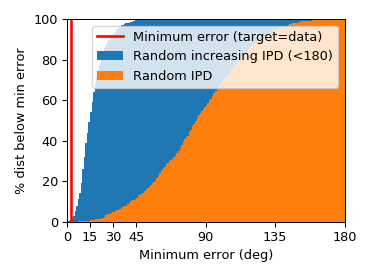

Random increasing IPD (<180): 0.7% below minimum error for target=data
Random IPD: 0.0% below minimum error for target=data


In [10]:
def parameter_space_curve_fitting_analysis(
        N, search_params,
        weighted=False, error_func_name="Max error",
        num_target_phases=1000,
        ):   
    # always use the same random seed for cacheing
    seed(34032483)
    # Get simple parameters
    error_func = error_functions[error_func_name]
    # Run the model
    res = simple_model(N, search_params, use_standalone_openmp=True, update_progress='text')
    res = simple_model_results(N, res, error_func, weighted=weighted, interpolate_bmf=False)
    
    # Compute scores for a randomly selected set of data
    figure(figsize=(4, 3), dpi=85)
    for randomisation_method_name, make_target_phase in [
                ('Random increasing IPD (<180)', lambda: sort(rand(len(dietz_fm))*pi)),
                ('Random IPD', lambda: rand(len(dietz_fm))*2*pi),
                ]:
        mse_min = []
        for _ in xrange(num_target_phases):
            target_phase = make_target_phase()
            mse = error_func(target_phase[newaxis, :], res.peak_phase) # sum over fm, mse has shape N
            mse_min.append(amin(mse))
        mse_min = array(mse_min)*180/pi
        hist(mse_min, linspace(0, 180, 181), label=randomisation_method_name,
             cumulative=True, weights=ones(len(mse_min))*100./len(mse_min))
        print '%s: %.1f%% below minimum error for target=data' % (randomisation_method_name,
                                                                  100.0*sum(mse_min<amin(res.mse)*180./pi)/num_target_phases)
    axvline(amin(res.mse)*180/pi, c='r', lw=2, label='Minimum error (target=data)')
    ylim(0, 100)
    xlim(0, 180)
    xticks([0,15,30,45,90,135,180])
    legend(loc='upper right')
    xlabel('Minimum error (deg)')
    ylabel('% dist below min error')
    tight_layout()
    
parameter_space_curve_fitting_analysis(N=50000, search_params=search_params)
#parameter_space_curve_fitting_analysis(N=800000, search_params=search_params)
#parameter_space_curve_fitting_analysis(N=4000000, search_params=search_params)
savefig('figure_single_neuron_model_curve_fitting_analysis.pdf')